#IMPORTS Y CONFIGURACION

In [195]:
#librerias que usamos que no vinene "instaladas" en colab
!pip install midiutil
#!pip install musescore

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [196]:
#numpy
import numpy as np ##para trabajar con arrays y transformadas

#matplotlib
import matplotlib.pyplot as plt ##para graficar diferentes aspectos del arhivo de audio

#IPython
import IPython.display as ipd ##para poder reproducir archivos de audio

#librosa
import librosa, librosa.display ##para cargar y procesar audio 


#no lo terminamos usando porque el usuario lo tiene que tener instalado y configurado
'''#musescore
from musescore import musescore #para la parte de mostrar el pentagrama''' 


#MIDIUtil
from midiutil import MIDIFile ##generar archivos MIDI

#music21
##para la parte de MIDI
from music21.tempo import MetronomeMark  ### para la parte de estimacion del tempo del audio
from music21.stream import Stream ### para crear un "stream" o linea de datos de musica
from music21.note import Note, Rest ### para crear notas y descansos en un stream
from music21 import metadata ### para agregarle los datos finales al stream 
from music21 import instrument ### para poder elegir un instrumento para el archivo midi
from music21 import midi ### para la parte de trabajo con midi
from music21.key import Key ### saca la tonalidad de un stream de music21

In [197]:
#parametros

sr = 44100 #frecuencia de samples
hop_length = 1024 #cantidad de samples entre "cuadros"
bins = 72 #espacios para guardar frecuencias
mag_exp = 4         
pre_post_max = 6                         
umbral = -60 #umbral para eliminar sonidos no deseados del cqt

In [198]:
# Funcion auxiliar para mapear la emplitud de la onda a los valores de "velocity" de MIDI
def remap(x, in_min, in_max, out_min, out_max):
    return (x - in_min) * (out_max - out_min) / (in_max - in_min) + out_min

In [199]:
#carga del audio
path = '/content/drive/MyDrive/Proyecto 2022'##ruta del archivo

filename = '/content/drive/MyDrive/Proyecto 2022/audio sinte.mp3'##nombre del archivo
x, sr = librosa.load(filename, mono=True, duration=None) ##carga el archivo
duration = (x.shape[0]/sr) ##duracion del audio

ipd.Audio(x, rate=sr) ##permite reproducir el archivo

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


In [269]:
#nombre con el que se va a guardar el archivo transcripto
nombreMidi = "audio"

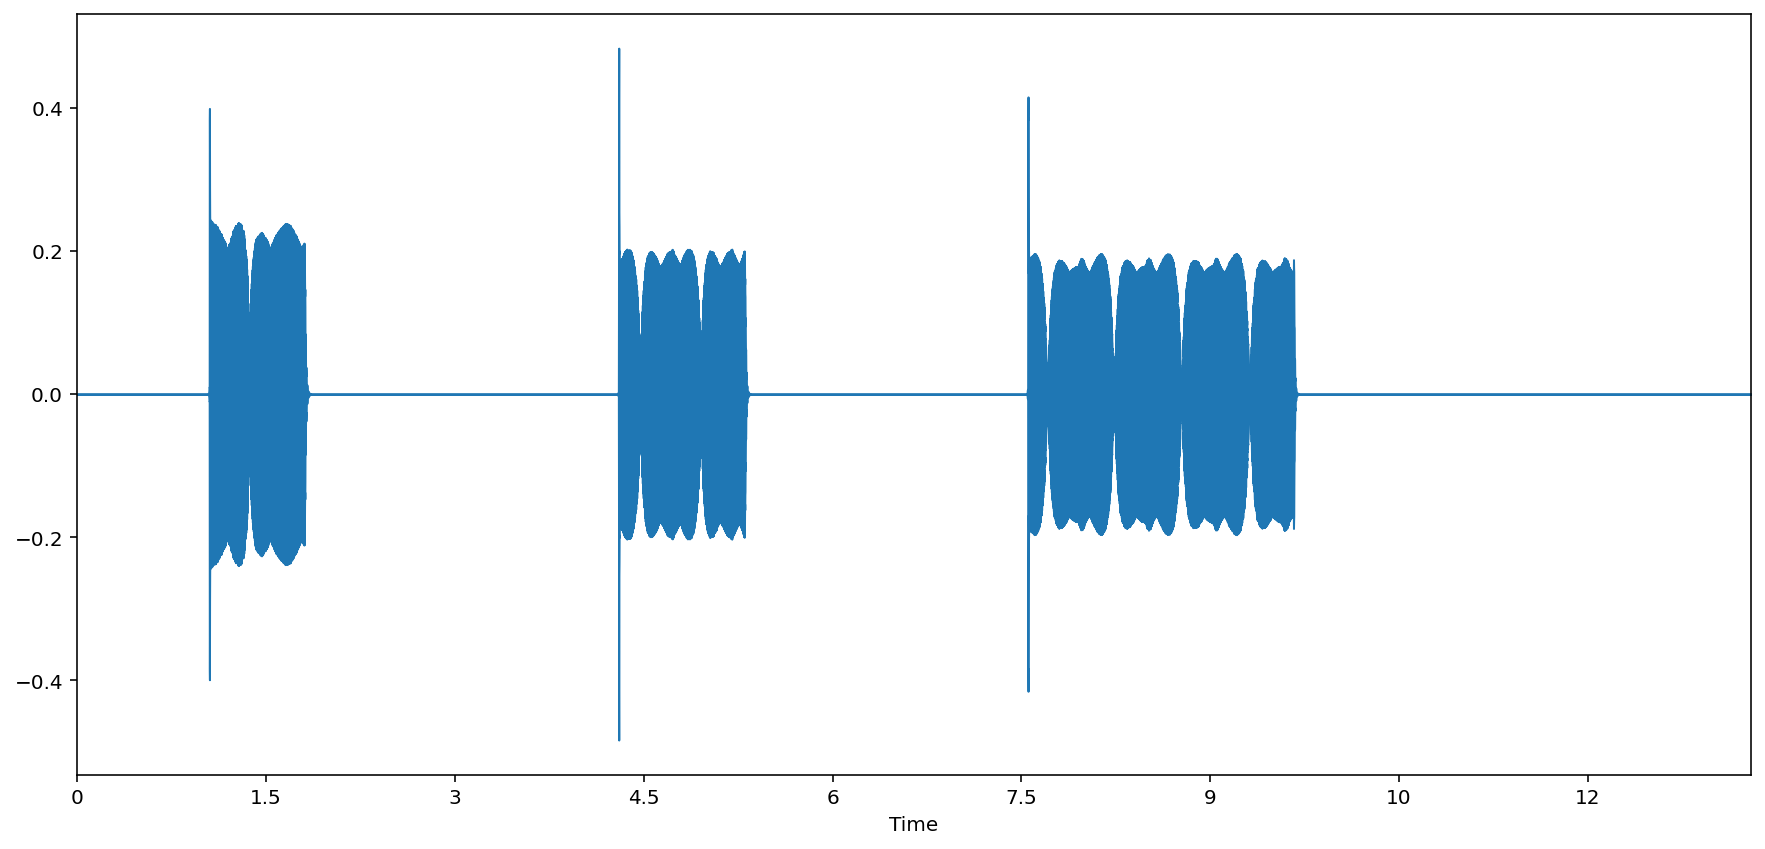

In [200]:
#forma de onda del audio
plt.figure(figsize=(15,7))
librosa.display.waveplot(x,sr)

# CQT



```
El CQT (Constant Q Transform) es un derivado de la transformada de Fourier que descompone una señal en las 
diferentes frecuencias que suenan a traves del tiempo
```



/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:1642: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  "amplitude_to_db was called on complex input so phase "


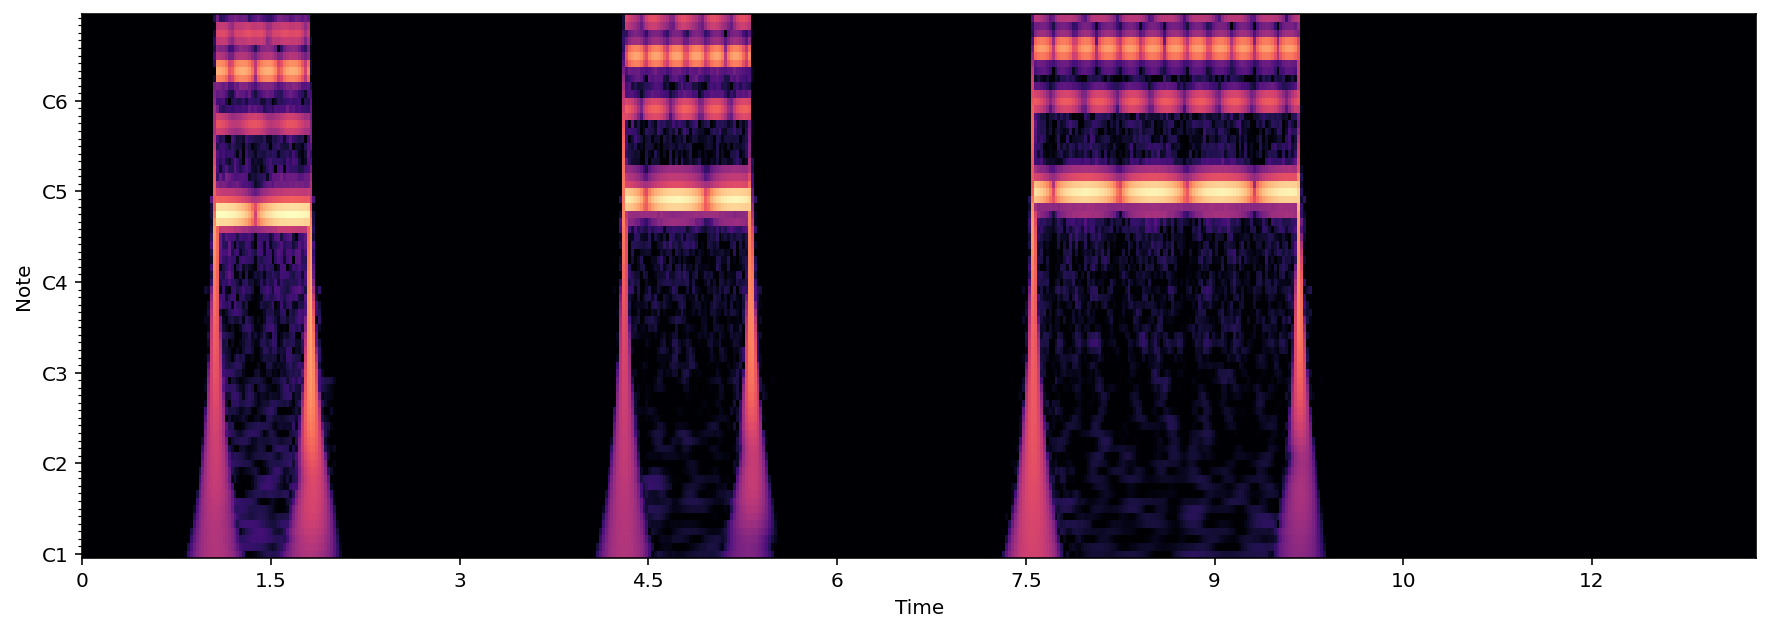

In [201]:
# Funcion para calcular el cqt
def calcular_cqt(x,fs=sr,hop_length=hop_length, n_bins=bins, mag_exp=mag_exp):
    cqt = librosa.cqt(x, sr=samplerate, n_bins=bins, bins_per_octave=12)#usamos una funcion integrada de librosa que calcula el cqt
    logCqt = librosa.amplitude_to_db(cqt)
    return cqt

## Grafico (espectrograma)
cqtGraph= librosa.amplitude_to_db(librosa.cqt(x, sr=sr, n_bins=bins, bins_per_octave=12))
plt.figure(figsize=(15, 5))
librosa.display.specshow(cqtGraph, sr=sr, x_axis='time', y_axis='cqt_note', fmin=None)

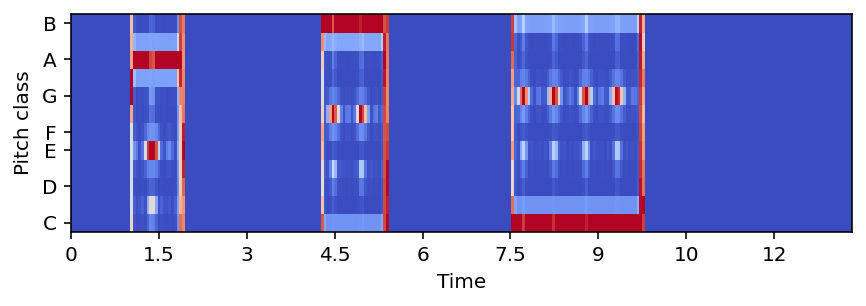

In [270]:
#extra para visualizar mejor las frecuencias ignorando los armónicos
cromagrama = librosa.feature.chroma_stft(x, sr=sr, hop_length=hop_length)
plt.figure(figsize=(7, 2))
librosa.display.specshow(cromagrama, x_axis='time', y_axis='chroma', hop_length=hop_length, cmap='coolwarm', fmin = None)

In [203]:
# umbral para el cqt
def cqt_umbral(cqt,thres=umbral):
    new_cqt=np.copy(cqt)
    new_cqt[new_cqt<thres]=-120 #si algun valor de el cqt es menor al umbral setea su valor a -120 (lo borra)
    return new_cqt

# ONSETS



```
Los onsets son lo que marcan cuando empieza y cuando termina cada nota. Basicamente se detectan cambios bruscos en la amplitud de la onda 
```



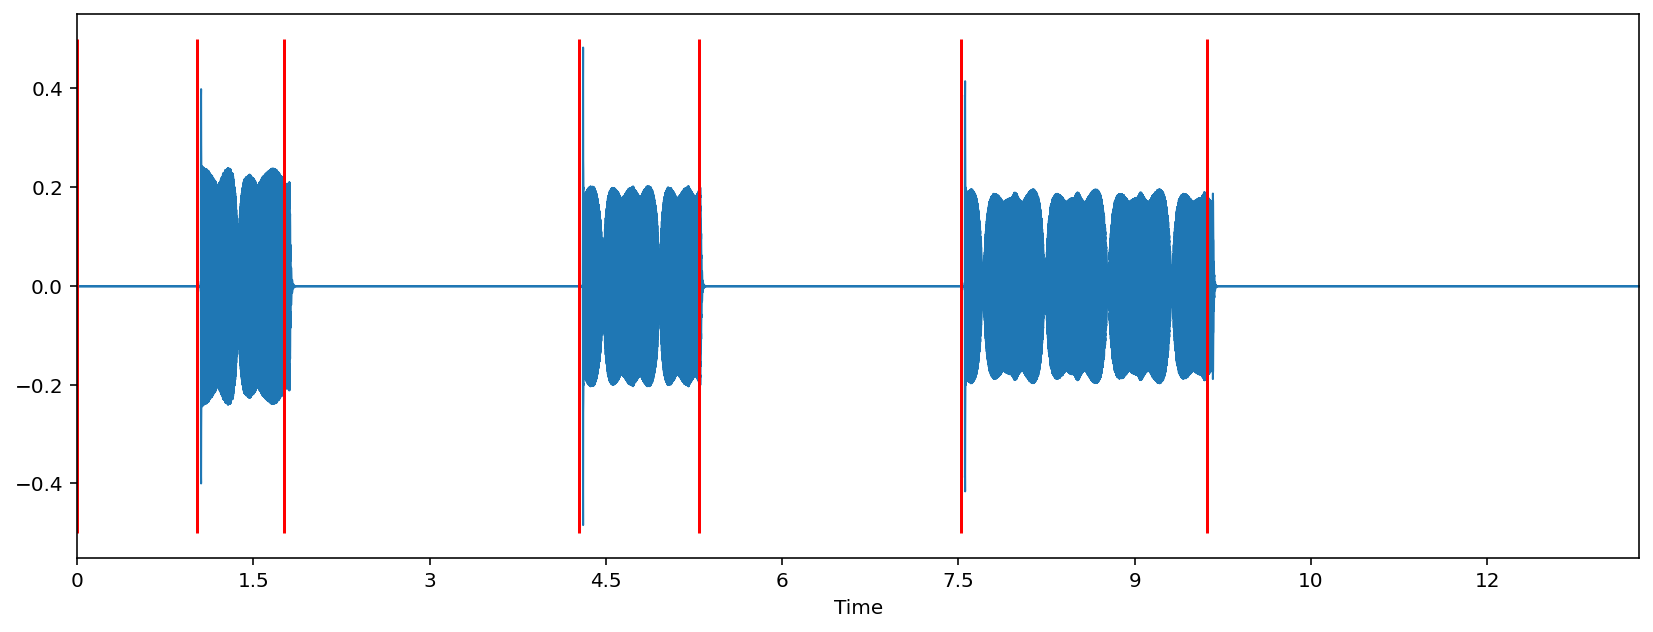

In [204]:
#calcular onsets
def calcular_onsets(cqt, pre_post_max=pre_post_max, backtrack=True):
    onset_env=librosa.onset.onset_strength(x, sr=sr, aggregate=np.mean, hop_length=hop_length)##detecta los picos en una señal
    onsets_en_frames = librosa.onset.onset_detect(onset_envelope=onset_env,
                                           sr=sr, units='frames', 
                                           hop_length=hop_length, 
                                           backtrack=backtrack,
                                           pre_max=pre_post_max,
                                           post_max=pre_post_max)
    
    onset_limites = np.concatenate([[0], onsets_en_frames, [cqt.shape[1]]])
    onset_segs = librosa.frames_to_time(onset_limites, sr=sr, hop_length=hop_length) ##convierte la estimacion de los onsets a segundos

    return [onset_segs, onset_limites, onset_env]

#grafico de los onsets sobre la forma de onda
plt.figure(figsize=(14, 5))
librosa.display.waveplot(x, sr=sr)
plt.vlines(onsets[0], -0.5, 0.5, color='red', alpha=1)

# OTROS ASPECTOS MUSICALES



```
sacamos cosas como el tempo, y estimamos las frecuencias
```



In [271]:
#Estimar Tempo
tempo, beats=librosa.beat.beat_track(y=None, sr=sr, onset_envelope=onsets[2], hop_length=hop_length,
               start_bpm=120.0, tightness=100, trim=True, bpm=None,
               units='frames')
tempo=int(2*round(tempo/2)) #Redondea la estimacion
metronomo = MetronomeMark(referent='quarter', number=tempo)

In [272]:
# pasa de segundos a semicorcheas (podriamos pasar a fusas pero por estadistica es lo mas preciso)
def tiempo_a_beat(duration, tempo):
    return (tempo*duration/60)

In [273]:
#Estimar Frecuencias
def estimar_frecuencias(segment, threshold):
    freqs = librosa.cqt_frequencies(n_bins=bins, fmin=librosa.note_to_hz('C1'),
                            bins_per_octave=12)
    if segment.max()<threshold:
        return [None, np.mean((np.amax(segment,axis=0)))]
    else:
        f0 = int(np.mean((np.argmax(segment,axis=0))))
    return [freqs[f0], np.mean((np.amax(segment,axis=0)))]



#Funcion que encontramos que estimaba las frecuencias usando la correlacion que al final no terminamos usando
'''    # Compute autocorrelation of input segment.
    correlacion = librosa.autocorrelate(segment)
    
    lim_min = sr/frec_max
    lim_max = sr/frec_min
    correlacion[:int(lim_min)] = 0
    correlacion[int(lim_max):] = 0
    
    # Find the location of the maximum autocorrelation
    i = correlacion.argmax()
    f0 = int(np.mean((np.argmax(segment,axis=0))))
    return [freqs[f0], np.mean((np.amax(segment,axis=0)))]'''

'    # Compute autocorrelation of input segment.\n    correlacion = librosa.autocorrelate(segment)\n    \n    lim_min = sr/frec_max\n    lim_max = sr/frec_min\n    correlacion[:int(lim_min)] = 0\n    correlacion[int(lim_max):] = 0\n    \n    # Find the location of the maximum autocorrelation\n    i = correlacion.argmax()\n    f0 = int(np.mean((np.argmax(segment,axis=0))))\n    return [freqs[f0], np.mean((np.amax(segment,axis=0)))]'

# TRANSCRIPCIÓN

In [274]:
#funcion que genera ondas senoidales con una formula
def generar_sinusoide(f0, sr, n_duration):
    n = np.arange (n_duration)
    return 0.2*np.sin(2*np.pi*f0*n/float(sr))

In [275]:
# Genera una transcripcion del audio a ondas senoidales, notas de music21 para luego pasarlas a MIDI

def genera_onda_y_nota(f0_info, sr, n_duration, round_to_sixteenth=True):
    
    f0=f0_info[0]
    A=remap(f0_info[1], cqt.min(), cqt.max(), 0, 1)
    duration = librosa.frames_to_time(n_duration, sr=sr, hop_length=hop_length)
    
    #Genera notas en el stream de music21
    duracion_nota = 0.02*np.around(duration/2/0.02) ##redondeamos la duracion de las notas ya que lo recomendaban en la documentacion
    duracion_midi = time_to_beat(duration, tempo) ##agarramos la duracion del audio en segundos y la pasamos a unidades de tempo
    velocidad_midi = int(round(remap(f0_info[1], cqt.min(), cqt.max(), 0, 127))) ##remapeamos las amplitudes de las frecuencias de 0-127 (estandares de MIDI)

    if round_to_sixteenth:
        duracion_midi=round(duracion_midi*16)/16
    if f0==None:
        midi_note=None 
        note_info=Rest(type=metronomo.secondsToDuration(duracion_nota).type) ##si no hay una nota pone un silencio
        f0=0

    else:
        midi_note=round(librosa.hz_to_midi(f0))
        note = Note(librosa.midi_to_note(midi_note), type=metronomo.secondsToDuration(duracion_nota).type)
        note.volume.velocity = velocidad_midi
        note_info = [note]
    midi_info = [midi_note, duracion_midi, velocidad_midi]
            
    #genera onda senoidal
    n = np.arange(librosa.frames_to_samples(n_duration, hop_length=hop_length))
    sine_wave = 0.2*np.sin(2*np.pi*f0*n/float(sr))
    return [sine_wave, midi_info, note_info]

In [276]:
##esta funcion la encontramos en uno de los modelos computacionales (genera notas a partir de la estimacion de las frecuencias)
def estimate_pitch_and_notes(x, onset_limites, i, sr):
    n0 = onset_limites[i]
    n1 = onset_limites[i+1]
    f0_info = estimar_frecuencias(np.mean(x[:,n0:n1],axis=1),threshold=umbral)
    
    return genera_onda_y_nota(f0_info, sr, n1-n0)

In [277]:
#array con todos los datos de MIR
music_info = np.array([
    estimate_pitch_and_notes(cqt, onsets[1], i, sr=sr)
    for i in range(len(onsets[1])-1)
])


notes=[]
for i in range(len(onsets[1])-1):
  notes.append(estimate_pitch_and_notes(cqt, onsets[1], i, sr=sr))
music_info=np.array(notes)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  # This is added back by InteractiveShellApp.init_path()


In [278]:
audio_senoidal=np.concatenate(music_info[:,0]) #le pasamos el array con la data y creamos un audio 
ipd.Audio(audio_senoidal, rate=sr)

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:1642: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  "amplitude_to_db was called on complex input so phase "


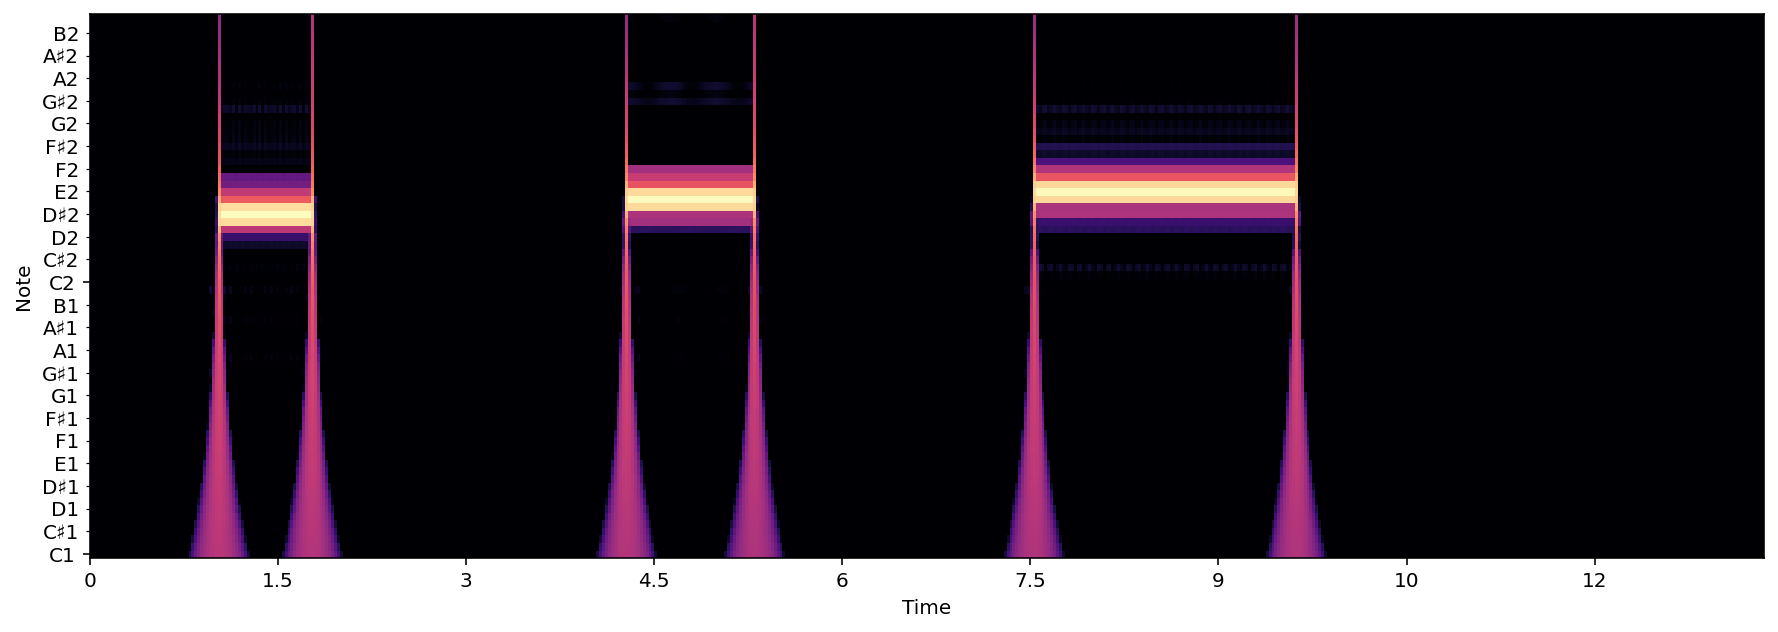

In [279]:
#cqt de la transcripcion a ondas senoidales
sinGraph= librosa.cqt(audio_senoidal, sr=sr, n_bins=bins, bins_per_octave=12)
sincqtGraph = librosa.amplitude_to_db(sinGraph)
plt.figure(figsize=(15,5))
librosa.display.specshow(sincqtGraph, sr=sr, x_axis='time', y_axis='cqt_note', bins_per_octave = 36, fmin=None)

In [281]:
note_info = list(music_info[:,2])
#creamos stream de music 21


s = Stream()
s.append(metronomo)
piano = instrument.Piano()
piano.midiChannel=0
s.append(piano)
s.insert(0, metadata.Metadata())
s.metadata.title = nombreMidi
s.metadata.composer = "Usuario"
for note in note_info:
    s.append(note)

In [282]:
#s.show() #esto mostraria el png del pentagrama pero hay que configurar musescore

In [283]:
# Another way for saving midi
midiFile = midi.translate.streamToMidiFile(s)
midiFile.open('audio' +'.mid', 'wb')
midiFile.write()
midiFile.close()

In [284]:
# Get MIDI Information
midi_info = list(music_info[:,1])

# GUARDADO DEL ARCHIVO

In [285]:
#Usamos MidiUtil para guardar toda la informacion obtenida en un archivo MIDI

track = 0 ##track de Midi
canal = 0 ##canal de midi (hay 16)
program = 1 ## le seteamos un sonido de piano
tempo = tempo ##tempo que obtuvimos

In [286]:
##le ponemos todo lo obtenido al archivo como parte de los datos que tiene 
transcripto = MIDIFile(1) 
transcripto.addTrackName(0,0,nombreMidi) 
transcripto.addProgramChange(track, canal, 0, program) 
transcripto.addTempo(track, 0, tempo)


## si no hay una nota pasa a la siguiente y le agrega toda la info
note_time=0
for i, note in enumerate(midi_info):
    if note[0]==None:
        note_time+=note[1]
    else:
        note_time+=note[1]
        transcripto.addNote(track, canal, note[0], note_time, note[1], note[2]) 

        
with open(nombreMidi + ".mid", "wb") as transcripcion_midi:
    transcripto.writeFile(transcripcion_midi)